In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import pymysql
import psycopg2
import datetime

In [2]:
def load_data(filetype='sql'):
    '''
    Loads the data from the given directory.
    Make sure to change the appropriate values within the function to load the correct data if needed.
    Parameters:
    filetype: Defines which filetype to read data from, where the default is SQL.
    '''
    if filetype == 'sql':
        dbcon = pymysql.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33061)
        data = pd.read_sql("SELECT * FROM SUMMARY order by timestamp desc limit 2000", dbcon)
    elif filetype == 'csv':
        data = pd.read_csv('summary.csv')
    elif filetype == 'xlsx':
        data = pd.read_excel('quasi_static.xlsx')
    data.replace([1.1e+308], np.nan, inplace=True) # Replace infinite values with nan
    data.fillna(np.nan, inplace=True) # Replace empty cells with nan
    data.dropna(axis=1,how='all',inplace=True) # Remove empty columns (sensors with no data for all timesteps)
    data = data.replace([np.nan], 0) # Replace all nan values with 0
    return data

def OrdinalToDatetime(ordinal):
    try:
        plaindate = datetime.date.fromordinal(int(ordinal))
    except:
        plaindate = datetime.date.fromordinal(1)
    date_time = datetime.datetime.combine(plaindate, datetime.datetime.min.time())
    return date_time + datetime.timedelta(days=ordinal-int(ordinal))

def transform_timestamp(stamp):
        try:
            return OrdinalToDatetime(stamp/(24*3600*1000)).strftime('%d-%m-%Y %H:%M:%S.%f')
        except:
            return stamp

def convert_timestamp(data):
    '''
    Convert the timestamp column within the data to a more readable format.
    The timestamp column will need to be in this format if specific dates are wanted to be choosed for training.
    Parameters:
    data: The dataframe containing all of the data. Note that the timestamp column is assumed to be the first column in the data.
    '''
    timestamps = data[data.columns[0]].values
    data[data.columns[0]] = [transform_timestamp(time) for time in timestamps]
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
    return data

def create_training_data(df):
    '''
    Create the training data from the original dataframe.
    Parameters:
    df: The dataframe for which the training data will be created.
    Returns:
    training_data: The training data dataframe.
    '''
    training_data = df.select_dtypes(include=np.number)
    training_data = (training_data - training_data.mean())/training_data.std()
    return training_data

In [3]:
# Load the data from the database
data_df = load_data()

# Convert the timestamp to a more readable style if wanted
#data_df = convert_timestamp(data_df)

# Create the training data from the original dataframe
training_data = create_training_data(data_df)

# Defines the size of the first layer of the autoencoder, which has to be equal to the length of the data (i.e. number of sensors).
size = training_data.shape[1]

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Create the autoencoder model to be used.
# Note that the layers within the model might need to be changed if the number of sensors is small.

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(size, size//2),
            nn.ReLU(True),
            nn.Linear(size//2, size//4),
            nn.ReLU(True),
            nn.Linear(size//4, 4)
        ).to(device)
        self.decoder = nn.Sequential(
            nn.Linear(4, size//4),
            nn.ReLU(True),
            nn.Linear(size//4, size//2),
            nn.ReLU(True),
            nn.Linear(size//2, size)
        ).to(device)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
# Define the parameters for the model
num_epochs=100
batch_size=128
learning_rate=1e-3
# Using a GPU which supports CUDA will make training the model faster
device = torch.device('cpu')#'cuda:0' if torch.cuda.is_available() else 'cpu')

# Change to change the ratio of training data to testing data
split_percentage = 0.15
train_test_split = int(np.round(split_percentage*len(data_df)))

# If preferred to create datasets between specific dates and times an example is below (the convert_timestamps function is required)
#train_test_split = data_df.loc[(data_df['timestamp'] > '2011-05-20') & (data_df['timestamp'] < '2012-06-30')]

# Load the training/testing data into tensors for the model
training_tensor_data = torch.from_numpy(training_data[:train_test_split].values.astype(np.float32)).to(device)
testing_tensor_data = torch.from_numpy(training_data[train_test_split:].values.astype(np.float32)).to(device)
load = DataLoader(training_tensor_data, batch_size=batch_size, shuffle=False)

# Create the model
model = AutoEncoder().to(device)
loss_func = nn.MSELoss().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)

In [6]:
# Set the model into training mode
model.train()

# Create a list to track the loss at each epoch
loss_list = []

# The loop for training the autoencoder model
for epoch in range(num_epochs):
    epoch_loss = 0
    for idx, item in enumerate(load):
        optimiser.zero_grad()
        output = model(item.to(device))
        loss = loss_func(output, item)
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
    print('Epoch %d, Loss = %f' %(epoch+1, epoch_loss))
    loss_list.append(epoch_loss)

Epoch 1, Loss = 6.590010
Epoch 2, Loss = 6.569834
Epoch 3, Loss = 6.551566
Epoch 4, Loss = 6.533658
Epoch 5, Loss = 6.515943
Epoch 6, Loss = 6.498367
Epoch 7, Loss = 6.480881
Epoch 8, Loss = 6.463451
Epoch 9, Loss = 6.446049
Epoch 10, Loss = 6.428650
Epoch 11, Loss = 6.411219
Epoch 12, Loss = 6.393721
Epoch 13, Loss = 6.376133
Epoch 14, Loss = 6.358416
Epoch 15, Loss = 6.340544
Epoch 16, Loss = 6.322478
Epoch 17, Loss = 6.304174
Epoch 18, Loss = 6.285657
Epoch 19, Loss = 6.267065
Epoch 20, Loss = 6.248398
Epoch 21, Loss = 6.229949
Epoch 22, Loss = 6.211741
Epoch 23, Loss = 6.193786
Epoch 24, Loss = 6.175798
Epoch 25, Loss = 6.157760
Epoch 26, Loss = 6.139707
Epoch 27, Loss = 6.121498
Epoch 28, Loss = 6.103270
Epoch 29, Loss = 6.085199
Epoch 30, Loss = 6.067288
Epoch 31, Loss = 6.049291
Epoch 32, Loss = 6.031107
Epoch 33, Loss = 6.012637
Epoch 34, Loss = 5.993848
Epoch 35, Loss = 5.974718
Epoch 36, Loss = 5.955218
Epoch 37, Loss = 5.935332
Epoch 38, Loss = 5.915017
Epoch 39, Loss = 5.89

In [7]:
# This cell will save the model to a file
torch.save(model.state_dict(), 'ae_model')

In [121]:
# Uncomment below line to load the model from a file
#model.load_state_dict(torch.load('ae_model'))

In [153]:
# Set model into evaluation mode
model.eval()

loss_list = []

# Put each item through the trained model, and calculate its loss
for i in range(len(testing_tensor_data)):
    data = testing_tensor_data[i]
    sample = model(data.to(device))
    loss = loss_func(data.to(device), sample)
    loss_list.append(loss.item())

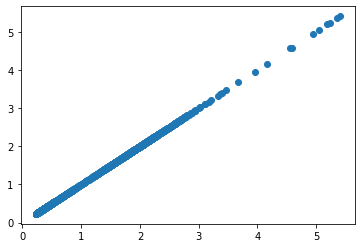

In [154]:
# Plot the losses as a linear function (can help visualise how well the model has been trained/tested)

loss_sc = []
for i in loss_list:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))

In [155]:
# Create the test data in reference to the original dataframe
test_data = data_df[train_test_split:]

# This parameter controls how sensitive the anomaly detection is: a bigger number will make the detection less sensitive
anomaly_sensitivity = [1,2,3,4,5]

indices = []
sensitivities = []

# Work out for each sensitivity which indicies (relating to the table) are anomalies
for sensitivity in anomaly_sensitivity:
    ind = np.array(np.argwhere(np.array(loss_list)>np.mean(loss_list)+(sensitivity*np.std(loss_list))).reshape(-1))
    indices.append(ind)
    sensitivities.append(np.full(len(ind), sensitivity))

sensitivities = np.concatenate(sensitivities)

In [157]:
# Create the loss 'confidence' (i.e., how big the loss value was for the detected anomaly) list

confidence = []
for i in range(len(anomaly_sensitivity)):
    confidence.append(np.array(loss_list)[indices[i]])

confidence = np.concatenate(confidence)

In [158]:
# Put all of the timestamps of the anomalies into a list

timestamps = []
for i in range(len(anomaly_sensitivity)):
    timestamps.append(np.array(test_data.iloc[indices[i]][test_data.iloc[indices[i]].columns[0]].values))

timestamps = np.concatenate(timestamps)

In [166]:
anomaly_df = test_data.iloc[indices[1]]

In [167]:
anomaly_df

,timestamp,TSH000ED,TSH000WD,TSH000CDT,TSH000CDB,NOAA_WIS,NOAA_WID,NOAA_TS,SCADA_AIR_TEMPERATURE,SCADA_WIND_SPEED,SCADA_WIND_DIRECTION
1221,63561943800000,11.6,22.4,17.4,12.2,3.216447,241.907486,8.005775,10.0,13.957844,247.991569
1222,63561942000000,13.2,22.8,17.0,12.0,3.217336,241.902488,8.004887,10.0,13.978730,247.995746
1223,63561940200000,15.0,22.5,16.1,11.6,3.218224,241.897490,8.003998,10.0,13.999617,247.999923
1359,63561695400000,13.9,14.9,18.2,16.0,3.339059,241.217792,7.883163,10.0,16.840203,248.568041
1360,63561693600000,14.5,16.4,19.2,16.6,3.339948,241.212794,7.882275,10.0,16.861090,248.572218
1361,63561691800000,15.1,18.6,20.4,17.2,3.340836,241.207797,7.881386,10.0,16.881976,248.576395
1362,63561690000000,15.8,20.2,21.2,17.6,3.341725,241.202799,7.880498,10.0,16.902863,248.580573
1363,63561688200000,16.3,21.6,22.3,17.7,3.342613,241.197801,7.879609,10.0,16.923750,248.584750
1364,63561686400000,16.8,22.5,22.7,17.8,3.343502,241.192803,7.878721,10.0,16.944636,248.588927
1365,63561684600000,17.4,24.2,22.6,17.5,3.344390,241.187805,7.877832,10.0,16.965523,248.593105


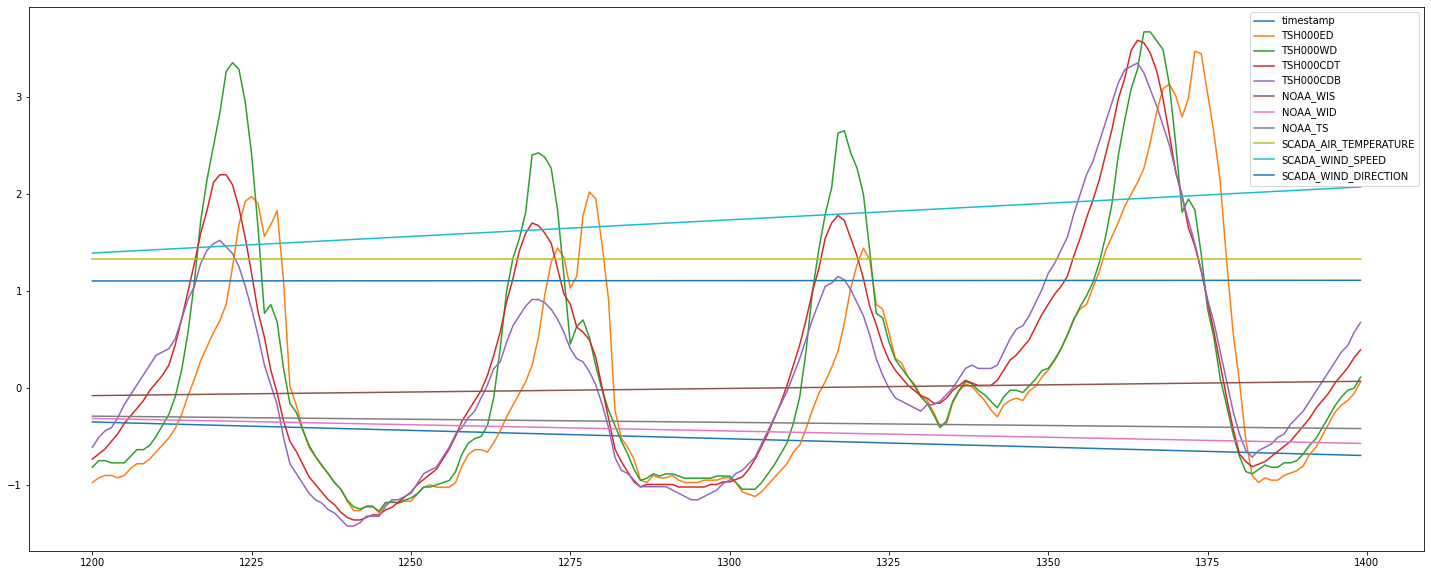

In [168]:
# Manually plot a figure based on the detected anomalies to see each of the sensors' data

plt.figure(figsize=(25,10))
plt.plot(training_data[1200:1400])
plt.legend(training_data.columns)
plt.show()

In [161]:
# Create a dataframe containing the relevant information about the anomalies

col_names = ['timestamps', 'sensitivity', 'confidence']
sql_df = pd.DataFrame([timestamps, sensitivities, confidence]).transpose()
sql_df.columns = col_names
records = sql_df.to_records(index=False)
result = list(records)

In [162]:
# Connect to the internal database and insert the details of the detected anomaly into it

dbcon2 = psycopg2.connect(user="root", password="example", database="humber_bridge", host="localhost", port=33062)
cur = dbcon2.cursor()
sql = "INSERT INTO anomalies_ae (sensor_time, sensitivity, confidence) VALUES(%s, %s, %s)"
for row in result:
    cur.execute(sql, row)
dbcon2.commit()
cur.close()